rework of ch_9_2_first_nns.ipnynb  
utilizing csv instead of loading as images   
3. 15x20 // NN // 3 - Live Data vs PerfectFam vs StreakMM

# IMPORTS

In [5]:
import random
import pickle
import glob

import random
import ast
import pathlib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# import matplotlib.transforms as transforms

from collections import Counter

from time import time
from time import sleep
from time import strftime
from time import localtime
from tqdm import tqdm

from datetime import date, timedelta, datetime

# from mydecorators import logger, stopwatch

from PIL import Image



In [7]:
import torch
import torch.nn as nn
import torchvision

import torch.nn.functional as F

import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset

import matplotlib.pyplot as plt



# Read CSV of All Data

In [12]:
df_alldata = pd.read_csv('combined_dataset.csv')
# display(df_alldata)

In [13]:
df_alldata.head()

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
0,0,0,1,0,0,0,0,0,0,1,...,1,0,0,1,0,0,0,1,2,perfectmm_456_0
1,1,0,1,1,0,0,1,1,0,0,...,1,0,1,0,1,1,1,0,2,perfectmm_456_1
2,1,1,1,0,1,0,1,0,0,0,...,1,0,0,1,0,1,1,0,2,perfectmm_456_2
3,1,1,1,1,1,1,1,0,1,0,...,0,1,1,0,0,1,0,1,2,perfectmm_456_3
4,1,0,0,0,0,0,0,1,1,1,...,1,0,0,0,1,0,1,1,2,perfectmm_456_4


# Prepare Dataframes
- Remove Live Data (0)  
- Check Labels ...   
=>  
Live Data : 0  
NearPerfectMM : 1    
PerfectMM : 2  
StreakMM : 3  

In [18]:
df_w_live = df_alldata.copy()

# display(df_wo_live)

## Check current labels

In [20]:
orig_labels = list(df_w_live['labels'])

In [22]:
len(orig_labels)

132127

In [28]:
set(orig_labels)
### 0: live_data
### 1: nearperfectmm
### 2: perfectmm
### 3: streakmm

{0, 1, 2, 3}

## Relabel Accordingly
live_data 0 -> 0  
nearperfectmm 1 -> 1  
perfectmm 2 -> 1   
streakmm 3 -> 2

In [32]:
replaced_labels = [1 if x==2 else x for x in orig_labels]
set(replaced_labels)

{0, 1, 3}

In [34]:
replaced_labels = [2 if x==3 else x for x in replaced_labels]
set(replaced_labels)

{0, 1, 2}

In [36]:
df_w_live['labels'] = replaced_labels

In [38]:
set(df_w_live['labels'])

{0, 1, 2}

## Display Current Dataframe

In [50]:
df_w_live[df_w_live['labels']==0].head(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
90000,1,1,1,0,1,1,1,0,1,0,...,0,1,1,1,0,1,1,0,0,좋은챔프
90001,0,1,0,0,0,0,0,0,0,0,...,1,1,0,0,0,1,1,1,0,진기장판


In [52]:
df_w_live[df_w_live['labels']==0].tail(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
132125,0,0,0,1,1,0,1,1,0,0,...,0,1,0,1,0,1,1,1,0,너가능성잇써
132126,0,1,0,1,0,1,1,0,1,1,...,0,0,0,0,0,1,1,0,0,토꽃


In [54]:
df_w_live[df_w_live['labels']==1].head(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
0,0,0,1,0,0,0,0,0,0,1,...,1,0,0,1,0,0,0,1,1,perfectmm_456_0
1,1,0,1,1,0,0,1,1,0,0,...,1,0,1,0,1,1,1,0,1,perfectmm_456_1


In [55]:
df_w_live[df_w_live['labels']==1].tail(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
59998,1,0,1,0,1,1,1,1,0,0,...,1,1,0,1,1,1,1,1,1,nearperfectmm_457_998
59999,0,1,1,1,0,0,1,0,0,1,...,1,1,1,0,1,1,0,1,1,nearperfectmm_457_999


In [58]:
df_w_live[df_w_live['labels']==2].head(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
60000,0,1,0,0,0,0,0,1,1,0,...,1,1,1,1,1,1,1,1,2,streakmm_412_0
60001,1,1,1,1,1,1,0,0,0,0,...,0,1,0,1,1,1,1,1,2,streakmm_412_1


In [60]:
df_w_live[df_w_live['labels']==3].head(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths


# Create Pytorch Dataset (custom)

## Define Dataset Class

In [66]:
# Custom Dataset Class
## Needs ATLEAST 3 class methods
## __init__, __len__, __getitem__

class RecordsDataset(Dataset):
    # This loads the data and converts it, make data rdy
    def __init__(self, pd_df):
        # load data
        self.df=pd_df
        # extract labels
        self.df_labels=self.df[['labels']]
        # drop non numeric columns to make tutorial simpler, in real life do categorical encoding
        # self.df=df.drop(columns=['Type','Color','Spectral_Class'])
        
        # convert to torch dtypes
        # self.dataset = self.df[[0,1]]
        # self.dataset=torch.tensor(self.df[[i for i in range(300)]].to_numpy()).float()
        self.dataset=torch.tensor(self.df[[str(i) for i in range(300)]].to_numpy()).float()
        # self.dataset = self.df[[str(i) for i in range(10)]]
        
        self.labels=torch.tensor(self.df_labels.to_numpy().reshape(-1))
    
    # This returns the total amount of samples in your Dataset
    def __len__(self):
        return len(self.dataset)
    
    # This returns given an index the i-th sample and label
    def __getitem__(self, idx):
        return self.dataset[idx],self.labels[idx]

## Instantiate Dataset Class

In [74]:
all_dataset = RecordsDataset(df_w_live)

## Split Train & Test

In [78]:
train_size = int(0.7 * len(all_dataset))
test_size = len(all_dataset) - train_size
train_alldataset, test_alldataset = torch.utils.data.random_split(all_dataset, [train_size, test_size])

In [80]:
train_alldataset
len(train_alldataset)

92488

In [82]:
test_alldataset
len(test_alldataset)

39639

## Create Train & Test all_dataloaders

In [86]:
train_alldataloader = torch.utils.data.DataLoader(train_alldataset, batch_size=32, shuffle=True)

In [88]:
test_alldataloader = torch.utils.data.DataLoader(test_alldataset, batch_size=32, shuffle=False)

### Check Train alldataloader

In [92]:
for images, labels in train_alldataloader:
    break

# images, labels = next(iter(dataloader))

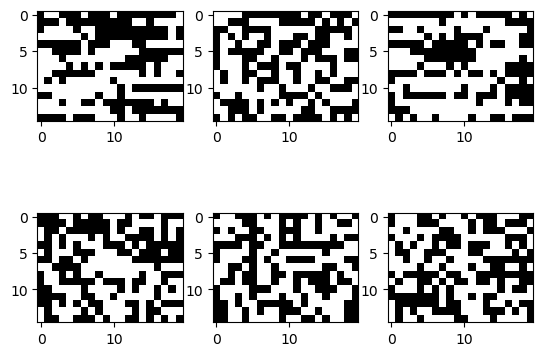

In [94]:
examples = iter(train_alldataloader)
# example_data, example_targets = examples.next()
example_data, example_targets = next(examples)

# example_data.shape
# example_data[0].reshape(15,20)


for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i].reshape(15,20), cmap='gray')
    # print(example_targets)
plt.show()

In [96]:
print(example_targets)

tensor([2, 1, 2, 0, 0, 1, 1, 2, 0, 1, 2, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
        2, 1, 1, 1, 0, 0, 1, 2])


### Check Test alldataloader

In [100]:
for images, labels in test_alldataloader:
    break

# images, labels = next(iter(dataloader))

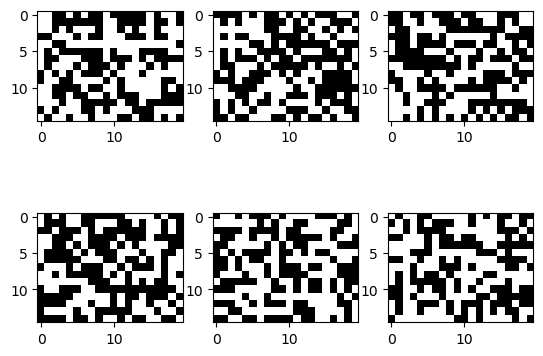

In [102]:
examples = iter(test_alldataloader)
# example_data, example_targets = examples.next()
example_data, example_targets = next(examples)


for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i].reshape(15,20), cmap='gray')
    # print(example_targets)
plt.show()

In [104]:
print(example_targets)

tensor([0, 1, 1, 1, 0, 0, 2, 1, 2, 0, 2, 1, 1, 1, 1, 1, 0, 0, 1, 2, 2, 2, 2, 1,
        1, 0, 0, 0, 2, 1, 0, 1])


# Create First Basic Neural Network
- Live Data vs (PerfectMM & NearPerfectMM) v StreakMM


## Configurations (Hyperparameters)

In [246]:
# Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# Hyperparameters
input_size = 300     #15*20
hidden_size = 120
num_classes = 3

# num_epochs = 10
# num_epochs = 50
# num_epochs = 100
num_epochs = 300

# batch_size = 100
learning_rate = 0.001

In [247]:
print(device)

mps


## Define Model

In [249]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # no activation and no softmax at the end
        return out
    
### 3.5s per epoch

## Train First Basic NN

In [251]:
start = time()
print(strftime('%Y-%m-%d %H:%M:%S', localtime()))
print('\n')
##############################################################################################################################



### Instantiate Model before training
model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
n_total_steps = len(train_alldataloader)

for epoch in tqdm(range(num_epochs)):
# for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_alldataloader):
        # origin shape: [100, 1, 28, 28]  -> from the code example (mnist)
        # resized: [100, 784] -> from the code example (mnist)
        images = images.reshape(-1, 15*20).to(device)
        labels = labels.to(device)

        # Forward pass and loss calculation
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # if (i+1) % 100 == 0:
        #     print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

            
            
            
##############################################################################################################################
print('\n----------------------------------------------------')
print("done in %0.3fs." % (time() - start))
print(strftime('%Y-%m-%d %H:%M:%S', localtime()))


### 15 * 20 //  secs

2024-05-20 23:12:28




100%|██████████| 300/300 [24:31<00:00,  4.90s/it]


----------------------------------------------------
done in 1471.059s.
2024-05-20 23:36:59


In [252]:
# labels

In [253]:
# model(images)

## Save First Basic NN

In [255]:
# PATH = './models/practice_2/first_basic_nn_20240520.pth'
PATH = f'./models/practice_3/first_basic_nn_3_{str(num_epochs)}epo.pth'
print(PATH)

./models/practice_3/first_basic_nn_3_300epo.pth


In [256]:
torch.save(model.state_dict(), PATH)

## Load First Basic NN

In [258]:
loaded_model = NeuralNet(input_size, hidden_size, num_classes).to(device)
loaded_model.load_state_dict(torch.load(PATH)) # it takes the loaded dictionary, not the path file itself
loaded_model.to(device)
loaded_model.eval()

NeuralNet(
  (l1): Linear(in_features=300, out_features=120, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=120, out_features=3, bias=True)
)

## Test First Basic NN

In [260]:
start = time()
print(strftime('%Y-%m-%d %H:%M:%S', localtime()))
print('\n')
##############################################################################################################################


# wrong_answers = []
all_answers = []

with torch.no_grad():
    n_correct = 0
    n_correct2 = 0
    n_samples = len(test_alldataloader.dataset)

    for images, labels in test_alldataloader:
        images = images.to(device)
        labels = labels.to(device)
        # outputs = model(images)

        # max returns (value ,index)
        outputs2 = loaded_model(images)
        _, predicted2 = torch.max(outputs2, 1)
        
        n_correct2 += (predicted2 == labels).sum().item()
        
        
        labels_list = labels.tolist()
        predicted2_list = predicted2.tolist()
        
        for i in range(len(labels_list)):
            # if predicted2_list[i] != labels_list[i]:
                # wrong_answers.append([labels_list[i], predicted2_list[i]])
                all_answers.append((int(labels_list[i]), predicted2_list[i]))
                
    acc = 100.0 * n_correct2 / n_samples
    print(f'Accuracy of the loaded model: {acc} %')
    

##############################################################################################################################
print('\n----------------------------------------------------')
print("done in %0.3fs." % (time() - start))
print(strftime('%Y-%m-%d %H:%M:%S', localtime()))
    
### 100 ~ 160s

### Accuracy of the loaded model: 53.94240267470429 % (2 epochs)



2024-05-20 23:36:59


Accuracy of the loaded model: 62.766467367996164 %

----------------------------------------------------
done in 1.048s.
2024-05-20 23:37:00


In [261]:
predicted2

tensor([2, 1, 0, 1, 2, 2, 0, 2, 2, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1],
       device='mps:0')

In [262]:
# print(len(wrong_answers))
print(len(all_answers))
print(type(all_answers))


39639
<class 'list'>


In [263]:
# Counter(all_answers)
all_answers_dict = dict(Counter(all_answers))
all_answers_dict = {key : all_answers_dict[key] for key in sorted(list(all_answers_dict.keys()))}

# all_answers_dict

###

for kkey in all_answers_dict:
    print(f'{kkey} : {all_answers_dict[kkey]}')



(0, 0) : 5833
(0, 1) : 6612
(0, 2) : 338
(1, 0) : 6841
(1, 1) : 10680
(1, 2) : 384
(2, 0) : 500
(2, 1) : 84
(2, 2) : 8367
